In [1]:
using Gadfly
using Vec, LinearAlgebra
using GridWorldPathFollowing

In [146]:
start_pt = VecE2(0.0,0.0)
start_time = 0.0
action_sequence = [DOWN,RIGHT,UP,RIGHT,RIGHT,RIGHT,DOWN,DOWN,LEFT,UP,LEFT,DOWN,LEFT,LEFT]
# action_sequence = [RIGHT,UP,RIGHT]
cell_width = 1.0
transition_time = 1.0
grid_path = construct_grid_world_path(start_pt,start_time,
    action_sequence,cell_width,transition_time)

traj = construct_trajectory(grid_path)
verify(traj)

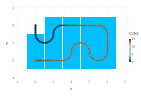

In [147]:
Δt = 0.01
t_range = get_start_time(traj):Δt:get_end_time(traj)
t_color_range = get_start_time(traj):(10*Δt):get_end_time(traj)
pad = 0.01
plot(
    layer(
        x=[get_position(traj,t).x for t in t_range],
        y=[get_position(traj,t).y for t in t_range],
        Geom.path,
        Theme(default_color="black")
        ),
    layer(
        x=[get_position(traj,t).x for t in t_color_range],
        y=[get_position(traj,t).y for t in t_color_range],
        color=[get_dist(traj,t) for t in t_color_range],
        Geom.point
        ),
    layer(
        xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        Geom.rect
    ),
    Coord.cartesian(fixed=true)
)

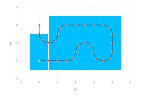

In [148]:
Δt = 0.01
t_range = get_start_time(traj):Δt:get_end_time(traj)
t_color_range = get_start_time(traj):(10*Δt):get_end_time(traj)
pad = 0.01
plot(
    layer(
        x=[get_position(traj,t).x for t in t_range],
        y=[get_position(traj,t).y for t in t_range],
        Geom.path,
        Theme(default_color="black")
        ),
    layer(
        x=[get_start_pt(seg).x for seg in traj.segments],
        y=[get_start_pt(seg).y for seg in traj.segments],
        Geom.point,
        Theme(default_color="red")
        ),
    layer(
        x=[get_end_pt(seg).x for seg in traj.segments],
        y=[get_end_pt(seg).y for seg in traj.segments],
        Geom.point,
        Theme(default_color="yellow")
        ),
    layer(
        xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        Geom.rect
    ),
    Coord.cartesian(fixed=true)
)

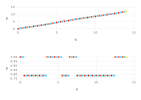

In [149]:
start_times = [get_start_time(seg) for seg in traj.segments]
final_times = [get_end_time(seg) for seg in traj.segments]
plot1 = plot(
    layer(x=start_times,y=[get_dist(traj,t) for t in start_times],Theme(default_color="red")),
    layer(x=final_times,y=[get_dist(traj,t) for t in final_times],Theme(default_color="yellow")),
    layer(x=collect(t_color_range),y=[get_dist(traj,t) for t in t_color_range])
)
plot2 = plot(
    layer(x=start_times,y=[norm(get_vel(traj,t)) for t in start_times],Theme(default_color="red")),
    layer(x=final_times,y=[norm(get_vel(traj,t)) for t in final_times],Theme(default_color="yellow")),
    layer(x=collect(t_color_range),y=[norm(get_vel(traj,t)) for t in t_color_range])
)
vstack(plot1,plot2)

# Optimize Velocity Profile
We apply a polynomial acceleration command in each time window

In [150]:
using Convex, ECOS, SCS

In [151]:
# t = 0.5
# n = 3
# a = ones(n) # coefficients
# Polynomial basis vector
tv(t,n) = [t^j for j in 0:n]
# a(t) = a[1] + a[2]*t + a[3]*t^2 + ... + a[n]*t^(n-1)
#      = a'*tv
# Differentiation
Dmat(n) = vcat([[i*(i == j-1) for j in 1:n+1]' for i in 1:n+1]...)
# d/dt a(t) = a[2] + 2*a[3]*t + ... + (n-1)*a[n]*t^(n-2)
#           = (Dmat*a)'*tv
# Integration from 0 to t
Imat(n) = vcat([[(1/j)*(i == j+1) for j in 1:n+1]' for i in 2:n+2]...);
# ∫ a(t) = a[1]*t + (1/2)*a[2]*t^2 + ... + (1/n)*a[n]*t^n
#        = (Imat*a)'*t*tv

In [157]:
N = length(traj.segments)
d = [get_length(seg) for seg in traj.segments]
cd = cumsum(d)
t = [[get_start_time(seg) for seg in traj.segments]..., get_end_time(traj)]
dt = diff(t)
v0 = 0.0
vT = 0.0
s0 = 0.0
sT = get_length(traj)

n = 0 # order of acceleration polynomial: a[i] = a_0 + a_1*t + a_2*t^2 + ... a_n*t^n
m = 4 # num accel windows (m per seg, equally spaced in time)
# each trajectory has a m-phase acceleration profile
a = [Variable(n+1,m) for t in 1:N] # accel cmd coefficients 
v = Variable(N+1)
s = Variable(N+1)

constraints = [
    [a[i] <= 10.0 for i in 1:N]...,
    [a[i] >= -10.0 for i in 1:N]...,
    v[1] == v0,    # initial conditions
    v[end] == vT,  # final conditions
    [v[i+1] == v[i] + sum((Imat(n)*(dt[i]/m)*a[i])'*tv((dt[i])/m, n)) for i in 1:N]...,
    s[1] == s0,
    s[end] == sT,
    [s[i+1] == cd[i] for i in 1:N]...,
    [s[i+1] == s[i] + v[i]*dt[i] + sum((((Imat(n)*(dt[i]/m))^2)*a[i])'*tv((dt[i])/m, n)) for i in 1:N]...,
]

# problem = minimize(sum([norm(A) for A in a]),constraints);
problem = minimize(sum([sumsquares(a[i]) for i in 1:N]),constraints);

In [158]:
solve!(problem, ECOSSolver(verbose=false))
@show problem.status;

problem.status = :Infeasible


┌ Warning: Problem status Infeasible; solution may be inaccurate.
└ @ Convex /Users/kyle/.julia/packages/Convex/HwTSz/src/solution.jl:48


In [160]:
for i in 1:N
    @show a[i].value
end
@show v.value
@show s.value;

(a[i]).value = [2.693 2.693 2.693 2.693]
(a[i]).value = [-1.55277 -1.55277 -1.55277 -1.55277]
(a[i]).value = [0.500318 0.500318 0.500318 0.500318]
(a[i]).value = [-0.175019 -0.175019 -0.175019 -0.175019]
(a[i]).value = [0.10651 0.10651 0.10651 0.10651]
(a[i]).value = [-0.194026 -0.194026 -0.194026 -0.194026]
(a[i]).value = [0.559881 0.559881 0.559881 0.559881]
(a[i]).value = [0.0228426 0.0228426 0.0228426 0.0228426]
(a[i]).value = [-0.0545068 -0.0545068 -0.0545068 -0.0545068]
(a[i]).value = [0.164231 0.164231 0.164231 0.164231]
(a[i]).value = [-0.509002 -0.509002 -0.509002 -0.509002]
(a[i]).value = [-0.16951 -0.16951 -0.16951 -0.16951]
(a[i]).value = [0.506134 0.506134 0.506134 0.506134]
(a[i]).value = [0.186784 0.186784 0.186784 0.186784]
(a[i]).value = [-0.562919 -0.562919 -0.562919 -0.562919]
(a[i]).value = [-0.00713948 -0.00713948 -0.00713948 -0.00713948]
(a[i]).value = [0.00298803 0.00298803 0.00298803 0.00298803]
(a[i]).value = [-0.00109983 -0.00109983 -0.00109983 -0.00109983]
(a